# I think I should clean this up and streamlinen it -- also worthwhile because I want to do this with a bin that has lots of alexandrium or something that we have reasonable confidence in the classifier results so lets begin here

## steps
1. load in and clean ADC HDR and Class
2. Create roi number in both ADC and Class file
3. Create instant inhibit time in ADC
4. Calculate instant volume analyzed in ADC
5. Merge volume analyzed to class on roi numner
6. create metric for is alexandrium -- i think binary makes sense and then sum
7. create running sum of Alexandrium and cells/ml
8. graph
9.

### Some more stuff I want to do to explore these classes 

# 1. load a dataframe for adc, header, and class 


In [116]:
# some chat code that creates functions to load clean data here - pulls header names from hdr file and uses them to build the adc df
import pandas as pd

def extract_adc_headers(hdr_file_path):
    """
    Extracts the ADCFileFormat headers from a .hdr file.
    """
    with open(hdr_file_path, 'r') as file:
        for line in file:
            if line.startswith("ADCFileFormat:"):
                header_line = line.strip().split(":", 1)[1]
                headers = [h.strip() for h in header_line.split(",")]
                return headers
    raise ValueError("ADCFileFormat not found in header file.")

def load_adc_data(adc_file_path, headers):
    """
    Loads the .adc file and applies the given headers to the DataFrame.
    """
    df = pd.read_csv(adc_file_path, header=None)
    df.columns = headers[:df.shape[1]]  # Handle case where fewer headers than columns
    return df

def main(hdr_path, adc_path):
    headers = extract_adc_headers(hdr_path)
    adc_df = load_adc_data(adc_path, headers)
    return adc_df

In [117]:
# use the functions to load the dataframe

if __name__ == "__main__":
    hdr_file = "../h_sampling/D20230704T185043_IFCB110.hdr"
    adc_file = "../h_sampling/D20230704T185043_IFCB110.adc"
    
    adc_df = main(hdr_file, adc_file)
    print(adc_df.head())  # or df.to_csv("output.csv", index=False) to save

   trigger#    ADCtime      PMTA      PMTB      PMTC      PMTD     PeakA  \
0         1   0.050336  1.331316 -0.004472 -0.004642 -0.001430  3.448689   
1         2   0.615637 -0.000440 -0.001075 -0.001326  0.000630  0.013752   
2         3   9.281782  1.062769 -0.009831 -0.013939 -0.007237  3.472238   
3         4  15.318527  0.001211 -0.001169 -0.001453  0.000579  0.013244   
4         5  15.704352  0.009617 -0.001217 -0.001553  0.000480  0.229220   

      PeakB     PeakC     PeakD  ...  RoiY  RoiWidth  RoiHeight  StartByte  \
0  0.014431  0.010881  0.011618  ...     0         0          0          0   
1  0.014112  0.010574  0.011280  ...     0         0          0          0   
2  0.019293  0.011060  0.073082  ...   614       384        220          0   
3  0.014129  0.010588  0.011292  ...     0         0          0          0   
4  0.014348  0.010810  0.011539  ...   174        96         84      84480   

   ComparatorOut  StartPoint  SignalLength  Status    RunTime  InhibitTime

In [120]:
# load the class file 
class_df = pd.read_csv('../h_sampling/D20230704T185043_IFCB110_class_vNone.csv')


In [121]:
print(class_df.columns.tolist())
print(class_df.head())

['pid', 'Acantharia', 'Acanthoica_quattrospina', 'Akashiwo', 'Alexandrium_catenella', 'Alexandrium_catenella_TAG_doublet', 'Amoeba', 'Amphidinium', 'Amylax', 'Apedinella', 'Asterionellopsis_glacialis', 'Bacillariophyceae_morphotype1', 'Balanion', 'Calciopappus', 'Cerataulina_pelagica', 'Chaetoceros', 'Chaetoceros_TAG_external_pennate', 'Chaetoceros_didymus', 'Chaetoceros_didymus_TAG_external_flagellate', 'Chaetoceros_morphotype1', 'Chaetoceros_socialis', 'Chaetoceros_tenuissimus', 'Chrysochromulina', 'Chrysochromulina_lanceolata', 'Ciliophora', 'Copepod_nauplii', 'Corethron_hystrix', 'Corymbellus', 'Coscinodiscus', 'Cryptophyta', 'Cylindrotheca', 'Dactyliosolen_blavyanus', 'Dactyliosolen_fragilissimus', 'Delphineis', 'Dictyocha', 'Dinobryon', 'Dinophysis_acuminata', 'Dinophysis_norvegica', 'Ditylum_brightwellii', 'Emiliania_huxleyi', 'Ephemera', 'Eucampia', 'Eucampia_morphytype1', 'Euglena', 'Euplotes', 'Euplotes_morphotype1', 'Eutintinnus', 'Favella', 'Fragilariopsis', 'Gonyaulax', 'G

# 2. Create ROI Numbers for ADC and Class and ensure they are the same
for ADC need to first create number for each line then remove zero roi from data set   
for class extract ROI number from PID 

In [122]:
# Creating ROI number in ADC file
# Add RoiNumber column starting from 1 in adc file
adc_df['RoiNumber'] = range(1, len(adc_df) + 1)
print(adc_df.head())

   trigger#    ADCtime      PMTA      PMTB      PMTC      PMTD     PeakA  \
0         1   0.050336  1.331316 -0.004472 -0.004642 -0.001430  3.448689   
1         2   0.615637 -0.000440 -0.001075 -0.001326  0.000630  0.013752   
2         3   9.281782  1.062769 -0.009831 -0.013939 -0.007237  3.472238   
3         4  15.318527  0.001211 -0.001169 -0.001453  0.000579  0.013244   
4         5  15.704352  0.009617 -0.001217 -0.001553  0.000480  0.229220   

      PeakB     PeakC     PeakD  ...  RoiWidth  RoiHeight  StartByte  \
0  0.014431  0.010881  0.011618  ...         0          0          0   
1  0.014112  0.010574  0.011280  ...         0          0          0   
2  0.019293  0.011060  0.073082  ...       384        220          0   
3  0.014129  0.010588  0.011292  ...         0          0          0   
4  0.014348  0.010810  0.011539  ...        96         84      84480   

   ComparatorOut  StartPoint  SignalLength  Status    RunTime  InhibitTime  \
0              0           0    

In [123]:
#clear out the zero ROIs
#nifty function from chat to remove zero roi rows
import pandas as pd

def remove_zero_roi_rows(df):
    """
    Remove rows from a DataFrame where RoiX, RoiY, RoiHeight, and RoiWidth are all 0.
    Returns a new cleaned DataFrame.
    """
    cleandf = df[~((df['RoiX'] == 0) & (df['RoiY'] == 0) &
                   (df['RoiHeight'] == 0) & (df['RoiWidth'] == 0))]

    print(f"Removed {len(df) - len(cleandf)} rows.")
    return cleandf





In [124]:
cleanadc_df = remove_zero_roi_rows(adc_df)

Removed 63 rows.


In [71]:
print(cleanadc_df['RoiNumber'].head())
print(cleanadc_df['RoiNumber'].tail())

2    3
4    5
5    6
6    7
7    8
Name: RoiNumber, dtype: int64
587    588
588    589
589    590
592    593
593    594
Name: RoiNumber, dtype: int64


In [127]:
print(cleanadc_df['RoiNumber'].duplicated().any())

False


In [130]:

# Select all rows where 'column_name' is duplicated
duplicated_rows = cleanadc_df[cleanadc_df['trigger#'].duplicated(keep=False)]

duplicated_rows.head(n=50).to_csv('DuplicateRois.csv')

In [72]:
# now to get rois from class we need to split the pid 
print(class_df['pid'].head())
print(class_df['pid'].tail())

0    D20230704T185043_IFCB110_00003
1    D20230704T185043_IFCB110_00005
2    D20230704T185043_IFCB110_00006
3    D20230704T185043_IFCB110_00007
4    D20230704T185043_IFCB110_00008
Name: pid, dtype: object
528    D20230704T185043_IFCB110_00588
529    D20230704T185043_IFCB110_00589
530    D20230704T185043_IFCB110_00590
531    D20230704T185043_IFCB110_00593
532    D20230704T185043_IFCB110_00594
Name: pid, dtype: object


In [73]:
#extract roi from PID from class files
class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

In [74]:
print(class_df['RoiNumber'].head())
print(class_df['RoiNumber'].tail())

0    3
1    5
2    6
3    7
4    8
Name: RoiNumber, dtype: int64
528    588
529    589
530    590
531    593
532    594
Name: RoiNumber, dtype: int64


#inspect roi numbers from ADC and and class are they they same -- are there the same number -- here YES!

### Inpect ROI numbers for both class and ADC files are they the same value and index - first pass looks like yes but here is some   code

In [75]:
# Reset index to align rows for element-wise comparison
roi_adc = cleanadc_df['RoiNumber'].reset_index(drop=True)
roi_class = class_df['RoiNumber'].reset_index(drop=True)

# Now compare them
differences = roi_adc != roi_class

if differences.any():
    print("Rows with different RoiNumbers:")
    print("cleaned_df values:")
    print(roi_clean[differences])
    print("\nclassdf values:")
    print(roi_class[differences])
else:
    print("All RoiNumbers match by position.")

All RoiNumbers match by position.


# Create instant inhibit time and histogram of these values
going to use the cleaned of zero rois for this because zero rois have zero inhibit time

In [76]:
cleanadc_df['InhibitTimeDiff'] = cleanadc_df['InhibitTime'].diff().fillna(0)

/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_43118/1853304302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanadc_df['InhibitTimeDiff'] = cleanadc_df['InhibitTime'].diff().fillna(0)


In [77]:
print(cleanadc_df.head())

   trigger#    ADCtime      PMTA      PMTB      PMTC      PMTD     PeakA  \
2         3   9.281782  1.062769 -0.009831 -0.013939 -0.007237  3.472238   
4         5  15.704352  0.009617 -0.001217 -0.001553  0.000480  0.229220   
5         6  17.529316  0.257779  0.095431 -0.009801 -0.004623  0.835750   
6         7  17.767288  0.068905  0.046107 -0.007543 -0.003253  0.163872   
7         8  24.326296  0.004792 -0.001060 -0.001305  0.000666  0.051358   

      PeakB     PeakC     PeakD  ...  RoiHeight  StartByte  ComparatorOut  \
2  0.019293  0.011060  0.073082  ...        220          0              0   
4  0.014348  0.010810  0.011539  ...         84      84480              0   
5  0.439847  0.011156  0.012755  ...        156      92544              0   
6  0.228620  0.010974  0.011673  ...        276     141216              0   
7  0.014224  0.010679  0.011413  ...         76     187584              0   

   StartPoint  SignalLength  Status    RunTime  InhibitTime  RoiNumber  \
2     

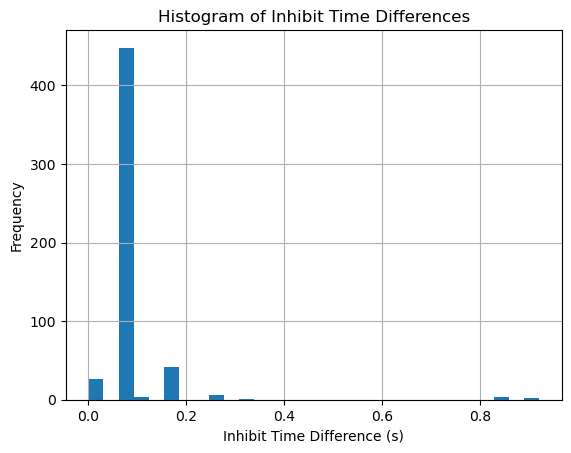

In [78]:
# plotting histogram of this diff time
import matplotlib.pyplot as plt

# Create histogram
cleanadc_df['InhibitTimeDiff'].hist(bins=30)  # You can adjust the number of bins

# Add labels and title
plt.xlabel('Inhibit Time Difference (s)')
plt.ylabel('Frequency')
plt.title('Histogram of Inhibit Time Differences')

# Show the plot
plt.show()

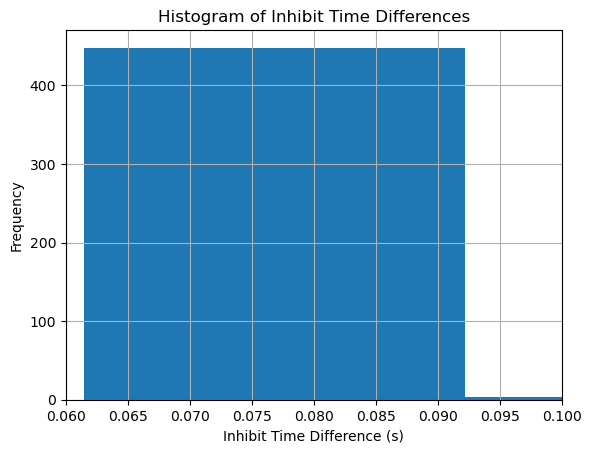

In [79]:
# plotting histogram of this diff time
import matplotlib.pyplot as plt

# Create histogram
cleanadc_df['InhibitTimeDiff'].hist(bins=30)  # You can adjust the number of bins

# Add labels and title
plt.xlabel('Inhibit Time Difference (s)')
plt.ylabel('Frequency')
plt.title('Histogram of Inhibit Time Differences')
plt.xlim(0.06,0.1)

# Show the plot
plt.show()

#### interesting that there are still 0 inhibit time here and that the inhibit times are much more vaired 
i wonder if I loop a bunch of data into this what it would look like -- i bet its a function of how full the sample is like how mnay images


# 4. Calculate the volume analyzed running tally

In [80]:
# Create VolumeAnalyzed
# First, ensure that the df is a clean copy, not just a filtered set
cleanadc_df = cleanadc_df.copy()
# Then, calculate the volume
cleanadc_df['VolumeAnalyzed'] = (cleanadc_df['RunTime']-cleanadc_df['InhibitTime'])/240

In [81]:
#check this against the volume shown on dashboard
print(cleanadc_df.head())
print(cleanadc_df.tail())

   trigger#    ADCtime      PMTA      PMTB      PMTC      PMTD     PeakA  \
2         3   9.281782  1.062769 -0.009831 -0.013939 -0.007237  3.472238   
4         5  15.704352  0.009617 -0.001217 -0.001553  0.000480  0.229220   
5         6  17.529316  0.257779  0.095431 -0.009801 -0.004623  0.835750   
6         7  17.767288  0.068905  0.046107 -0.007543 -0.003253  0.163872   
7         8  24.326296  0.004792 -0.001060 -0.001305  0.000666  0.051358   

      PeakB     PeakC     PeakD  ...  StartByte  ComparatorOut  StartPoint  \
2  0.019293  0.011060  0.073082  ...          0              0           0   
4  0.014348  0.010810  0.011539  ...      84480              0           0   
5  0.439847  0.011156  0.012755  ...      92544              0           0   
6  0.228620  0.010974  0.011673  ...     141216              0           0   
7  0.014224  0.010679  0.011413  ...     187584              0           0   

   SignalLength  Status    RunTime  InhibitTime  RoiNumber  InhibitTimeDif

# 5. Merge VolumeAnalyzed to class file

In [82]:
# Merge just the RoiNumber and VolumeAnalyzed columns into classdf on roi number
class_df = class_df.merge(
    cleanadc_df[['RoiNumber', 'VolumeAnalyzed','RunTime']],
    on='RoiNumber',
    how='left'  # or 'inner' if you want only matching rows
)


In [83]:
print(class_df.columns.tolist()) # inspect 

['pid', 'Acantharia', 'Acanthoica_quattrospina', 'Akashiwo', 'Alexandrium_catenella', 'Alexandrium_catenella_TAG_doublet', 'Amoeba', 'Amphidinium', 'Amylax', 'Apedinella', 'Asterionellopsis_glacialis', 'Bacillariophyceae_morphotype1', 'Balanion', 'Calciopappus', 'Cerataulina_pelagica', 'Chaetoceros', 'Chaetoceros_TAG_external_pennate', 'Chaetoceros_didymus', 'Chaetoceros_didymus_TAG_external_flagellate', 'Chaetoceros_morphotype1', 'Chaetoceros_socialis', 'Chaetoceros_tenuissimus', 'Chrysochromulina', 'Chrysochromulina_lanceolata', 'Ciliophora', 'Copepod_nauplii', 'Corethron_hystrix', 'Corymbellus', 'Coscinodiscus', 'Cryptophyta', 'Cylindrotheca', 'Dactyliosolen_blavyanus', 'Dactyliosolen_fragilissimus', 'Delphineis', 'Dictyocha', 'Dinobryon', 'Dinophysis_acuminata', 'Dinophysis_norvegica', 'Ditylum_brightwellii', 'Emiliania_huxleyi', 'Ephemera', 'Eucampia', 'Eucampia_morphytype1', 'Euglena', 'Euplotes', 'Euplotes_morphotype1', 'Eutintinnus', 'Favella', 'Fragilariopsis', 'Gonyaulax', 'G

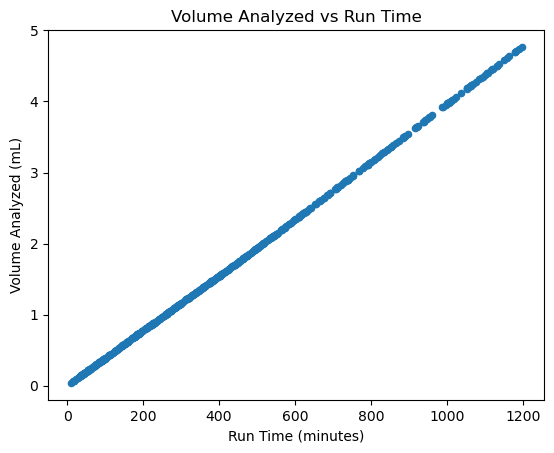

In [84]:
import matplotlib.pyplot as plt

ax = class_df.plot(x='RunTime', y='VolumeAnalyzed', kind='scatter')
ax.set_xlabel('Run Time (minutes)')
ax.set_ylabel('Volume Analyzed (mL)')
ax.set_title('Volume Analyzed vs Run Time')

plt.show()

# 6. Create metric for Alexandrium is or is not 
first lets explore the distribution of alexandrium values and then set a threshhold from there


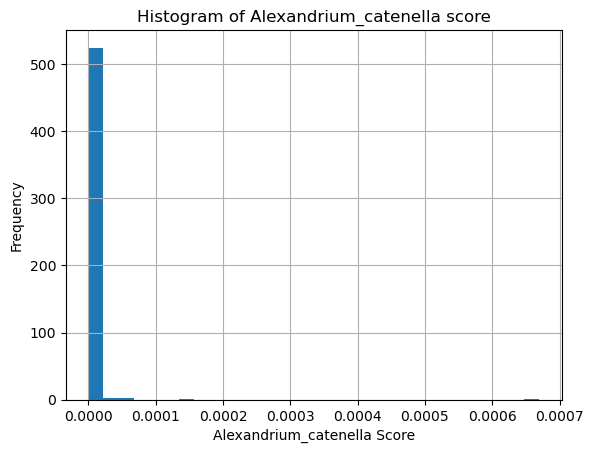

In [85]:
# plotting histogram of this diff time
import matplotlib.pyplot as plt

# Create histogram
class_df['Alexandrium_catenella'].hist(bins=30)  # You can adjust the number of bins

# Add labels and title
plt.xlabel('Alexandrium_catenella Score')
plt.ylabel('Frequency')
plt.title('Histogram of Alexandrium_catenella score')
#plt.xlim(0,0.2)

# Show the plot
plt.show()

In [86]:
class_df['Alexandrium_catenella'].median()

np.float64(0.0)

In [87]:
count = (class_df['Alexandrium_catenella'] > 0.9).sum()
print(f"Number of values > 0.9: {count}")

Number of values > 0.9: 0


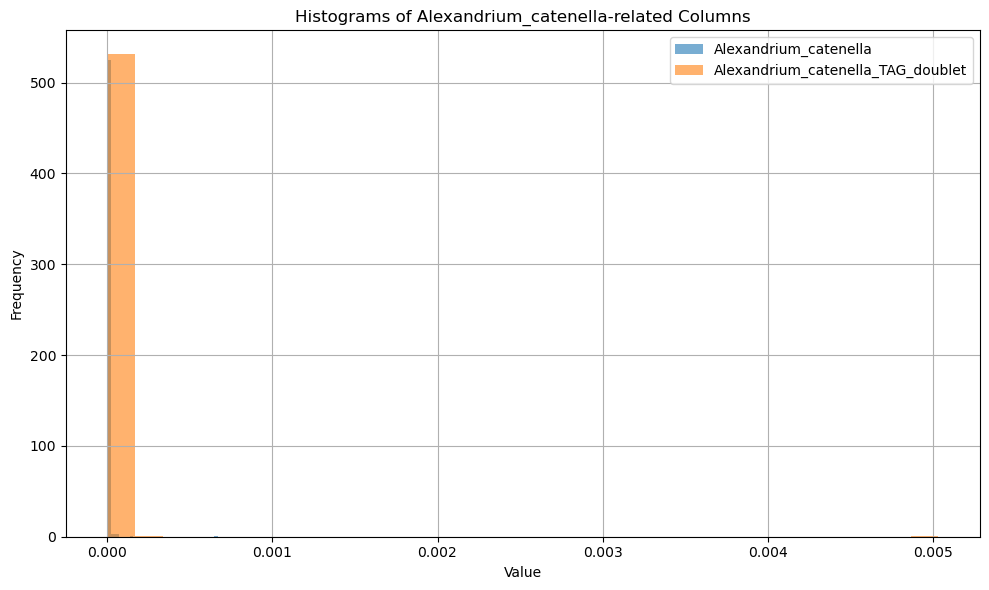

In [88]:
# some code from chat to put all alex even with tags on the same histogram

# Find all columns that contain 'Alexandrium_catenella'
ac_columns = [col for col in class_df.columns if "Alexandrium_catenella" in col]

# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot each relevant column's histogram
for col in ac_columns:
    plt.hist(class_df[col].dropna(), bins=30, alpha=0.6, label=col)

# Add labels and formatting
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histograms of Alexandrium_catenella-related Columns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### this is neat but will probably just go with what mrun sugested of greater than 0.95 

In [89]:
# make a binary operator for is alexandrium in all column including alex in name and highher than 0.95

# Identify all columns containing 'Alexandrium_catenella'
alex_columns = [col for col in class_df.columns if 'Alexandrium_catenella' in col]

# Create 'isAlexandrium' = 1 if any value > 0.95 across those columns, else 0
class_df['isAlexandrium'] = (class_df[alex_columns] > 0.95).any(axis=1).astype(int)



In [90]:
print(class_df['isAlexandrium'].head(n=50))

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: isAlexandrium, dtype: int64


# 7. Make a Cumulative total of Alexandrium and a concentration 

In [91]:
# create a cumulative sum of this binary opperator --this will just be equal to total alex
class_df['TotalAlexandrium'] = class_df['isAlexandrium'].cumsum()


In [92]:
print(class_df['TotalAlexandrium'].tail())


528    0
529    0
530    0
531    0
532    0
Name: TotalAlexandrium, dtype: int64


In [93]:
class_df['AlexandriumConcentration'] = class_df['TotalAlexandrium'] / class_df['VolumeAnalyzed']

In [94]:
print(class_df['AlexandriumConcentration'].head())
print(class_df['AlexandriumConcentration'].tail())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: AlexandriumConcentration, dtype: float64
528    0.0
529    0.0
530    0.0
531    0.0
532    0.0
Name: AlexandriumConcentration, dtype: float64


# 8. Graph!

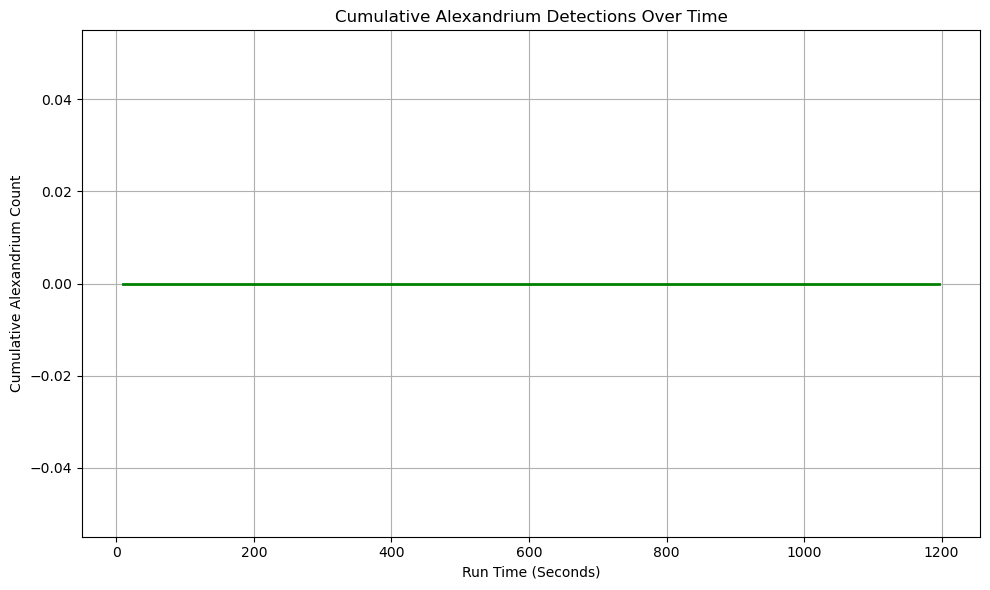

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(class_df['RunTime'], class_df['TotalAlexandrium'], color='green', linewidth=2)

plt.xlabel('Run Time (Seconds)')
plt.ylabel('Cumulative Alexandrium Count')
plt.title('Cumulative Alexandrium Detections Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

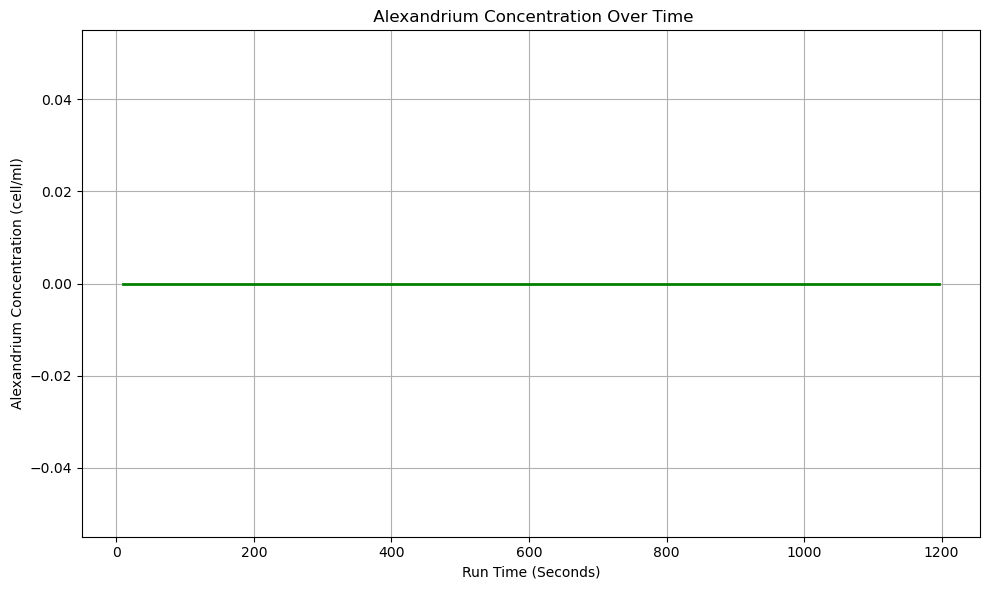

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(class_df['RunTime'], class_df['AlexandriumConcentration'], color='green', linewidth=2)

plt.xlabel('Run Time (Seconds)')
plt.ylabel('Alexandrium Concentration (cell/ml)')
plt.title(' Alexandrium Concentration Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

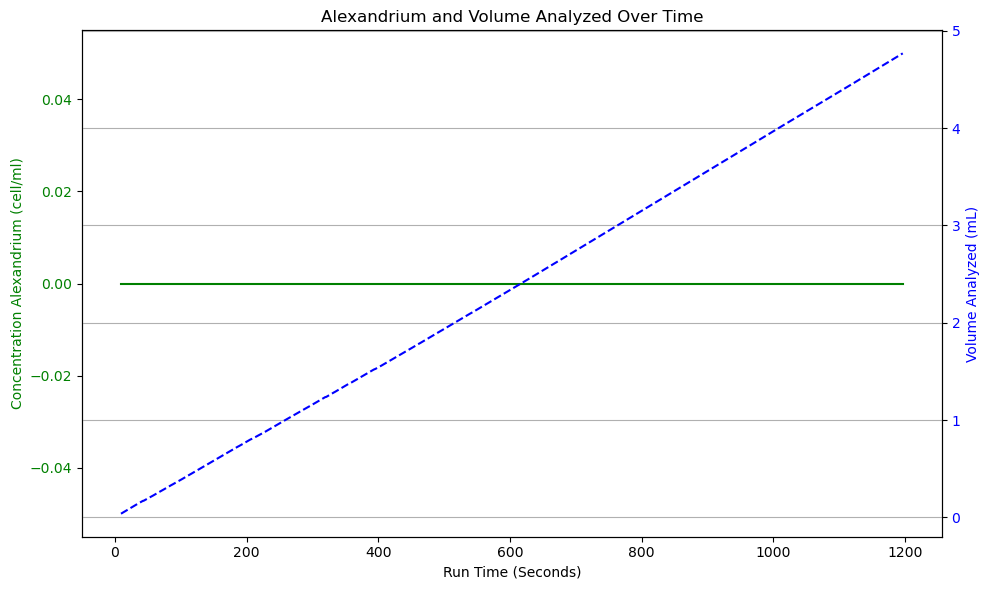

In [97]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: TotalAlexandrium
ax1.plot(class_df['RunTime'], class_df['AlexandriumConcentration'], color='green', label='Concentration Alexandrium')
ax1.set_xlabel('Run Time (Seconds)')
ax1.set_ylabel('Concentration Alexandrium (cell/ml)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Right Y-axis: VolumeAnalyzed
ax2 = ax1.twinx()
ax2.plot(class_df['RunTime'], class_df['VolumeAnalyzed'], color='blue', linestyle='--', label='Volume Analyzed')
ax2.set_ylabel('Volume Analyzed (mL)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Titles and layout
plt.title('Alexandrium and Volume Analyzed Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()

## that is pretty sweet! It does not look exactly as we expected but might be diffefrent for shellfish -- I also think that the particle movement in the syringe will have a huge impact on this if we think that the shellfish are settling in the syringe we might see a big spike at the beginning somehwhat similar to this and then a trailing off as we analze more images 

In [98]:
##  what happens if we just graph concentration vs volume analyzed


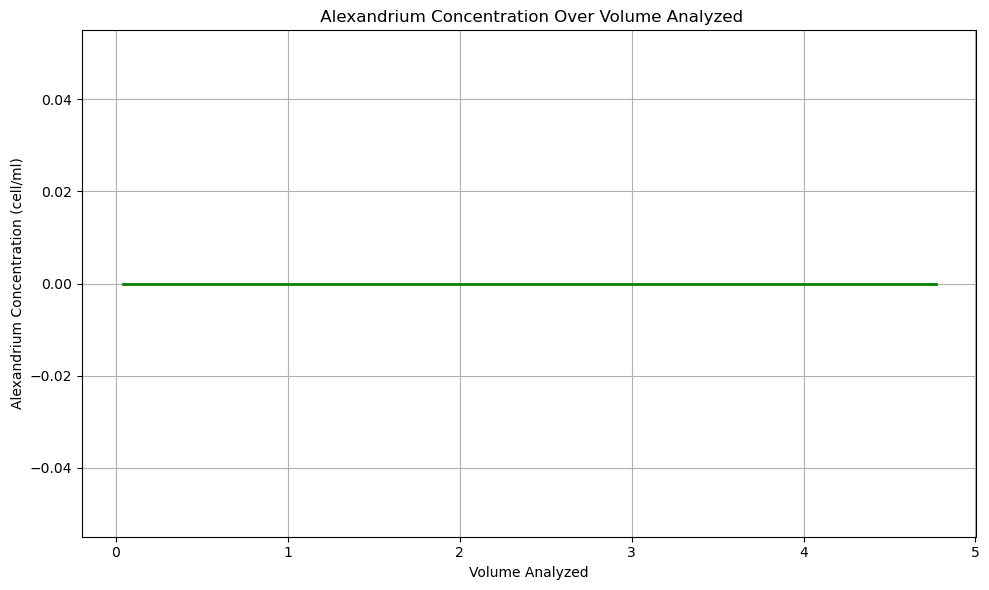

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(class_df['VolumeAnalyzed'], class_df['AlexandriumConcentration'], color='green', linewidth=2)

plt.xlabel('Volume Analyzed')
plt.ylabel('Alexandrium Concentration (cell/ml)')
plt.title(' Alexandrium Concentration Over Volume Analyzed')
plt.grid(True)
plt.tight_layout()
plt.show()

## Some more exploration into the adc file like what the heck is a flight time


In [100]:
print(cleanadc_df.columns.tolist())

['trigger#', 'ADCtime', 'PMTA', 'PMTB', 'PMTC', 'PMTD', 'PeakA', 'PeakB', 'PeakC', 'PeakD', 'TimeOfFlight', 'GrabTimeStart', 'GrabTimeEnd', 'RoiX', 'RoiY', 'RoiWidth', 'RoiHeight', 'StartByte', 'ComparatorOut', 'StartPoint', 'SignalLength', 'Status', 'RunTime', 'InhibitTime', 'RoiNumber', 'InhibitTimeDiff', 'VolumeAnalyzed']


In [101]:
print(cleanadc_df['TimeOfFlight'].tail())
print(cleanadc_df['TimeOfFlight'].min())
print(cleanadc_df['TimeOfFlight'].max())


587    58.695652
588    58.695652
589     2.173913
592    56.521740
593    58.695652
Name: TimeOfFlight, dtype: float64
2.173913
291.30435


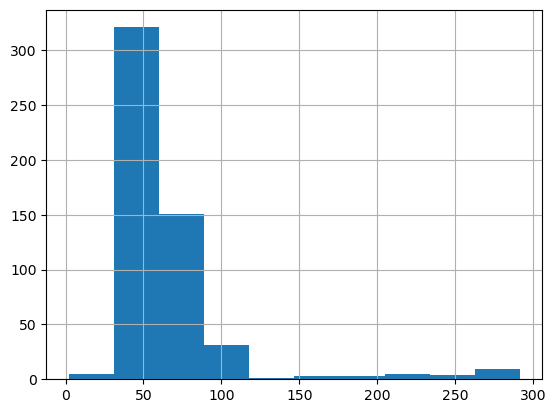

In [102]:
# plotting histogram of this diff time
import matplotlib.pyplot as plt

# Create histogram
cleanadc_df['TimeOfFlight'].hist()  # You can adjust the number of bins

# Add labels and title
#plt.xlabel('Alexandrium_catenella Score')
#plt.ylabel('Frequency')
#plt.title('Histogram of Alexandrium_catenella score')
#plt.xlim(50,100)

# Show the plot
plt.show()

In [103]:
## well that did not help I have no idea what the range could be from 50 to 9336743000

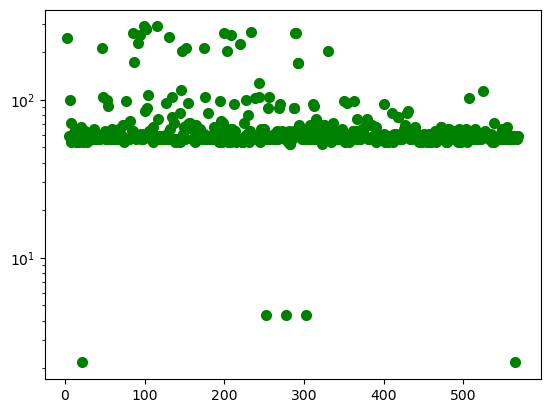

In [104]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
plt.scatter(cleanadc_df['trigger#'], cleanadc_df['TimeOfFlight'], color='green', linewidth=2)

#plt.xlabel('Volume Analyzed')
#plt.ylabel('Alexandrium Concentration (cell/ml)')
#plt.title(' Alexandrium Concentration Over Volume Analyzed')
#plt.grid(True)
#plt.tight_layout()
plt.yscale('log') 
plt.show()

## I want to just make a plot of triggers over time really simple and then it would be cool to see if we can do like a size distributuon of images over time so like x axis is time y axis is image size

In [105]:
print(cleanadc_df.columns.tolist())

['trigger#', 'ADCtime', 'PMTA', 'PMTB', 'PMTC', 'PMTD', 'PeakA', 'PeakB', 'PeakC', 'PeakD', 'TimeOfFlight', 'GrabTimeStart', 'GrabTimeEnd', 'RoiX', 'RoiY', 'RoiWidth', 'RoiHeight', 'StartByte', 'ComparatorOut', 'StartPoint', 'SignalLength', 'Status', 'RunTime', 'InhibitTime', 'RoiNumber', 'InhibitTimeDiff', 'VolumeAnalyzed']


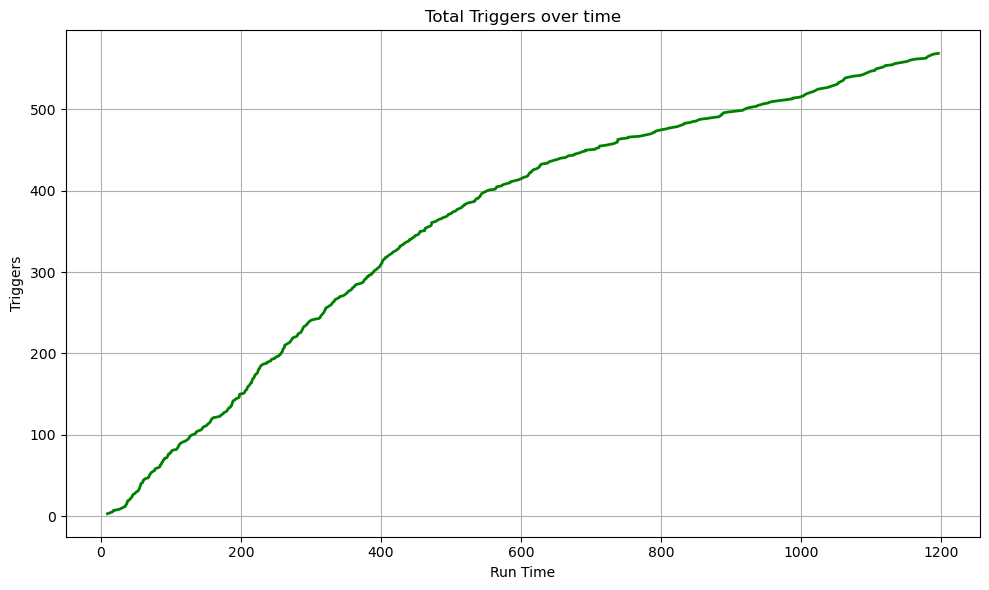

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(cleanadc_df['RunTime'], cleanadc_df['trigger#'], color='green', linewidth=2)

plt.xlabel('Run Time')
plt.ylabel('Triggers')
plt.title('Total Triggers over time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
## so atleast in this example the relationship is pretty linear


### now I need a size metric I think i can just miltuply roiwidt and hight to make roi area

In [108]:
print(cleanadc_df['RoiWidth'].head(n=20))
print(cleanadc_df['RoiHeight'].head(n=20))

2     384
4      96
5     312
6     168
7      88
8     120
9      96
10    112
11    120
12    224
13    360
14    128
15     72
16    184
17     72
18     80
19     96
20     96
21    104
22     80
Name: RoiWidth, dtype: int64
2     220
4      84
5     156
6     276
7      76
8     108
9      68
10     60
11     68
12     84
13     84
14    108
15     44
16    164
17     68
18     68
19     68
20     84
21    108
22     68
Name: RoiHeight, dtype: int64


In [109]:
cleanadc_df['RoiArea'] = cleanadc_df['RoiHeight'] * cleanadc_df['RoiWidth']

In [110]:
print(cleanadc_df['RoiArea'].head())

2    84480
4     8064
5    48672
6    46368
7     6688
Name: RoiArea, dtype: int64


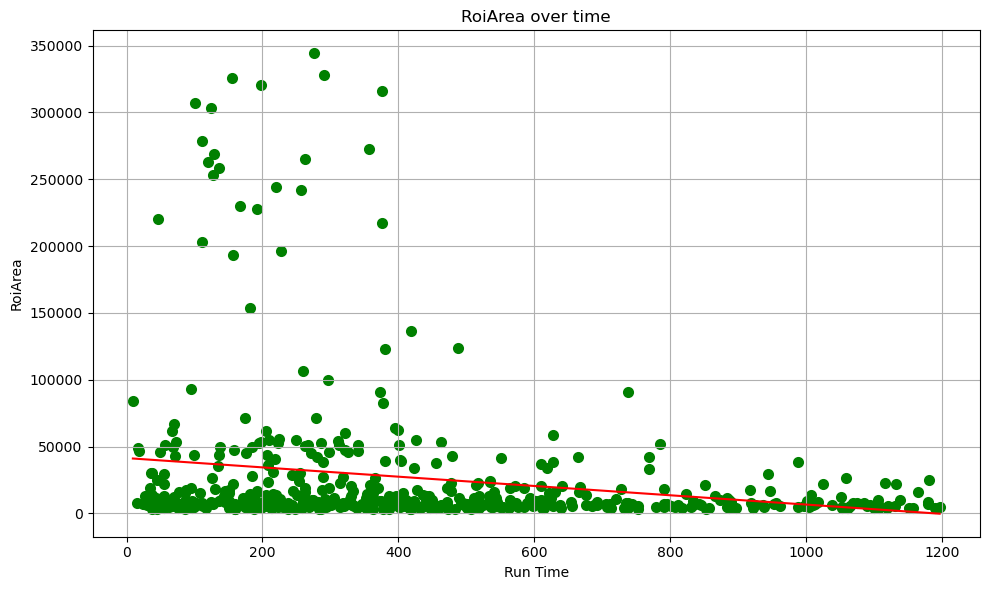

In [111]:
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(cleanadc_df['RunTime'], cleanadc_df['RoiArea'], color='green', linewidth=2)

# Fit a linear trend line
coeffs = np.polyfit(cleanadc_df['RunTime'], cleanadc_df['RoiArea'], 1)  # 1 = linear
fit_line = np.poly1d(coeffs)
plt.plot(cleanadc_df['RunTime'], fit_line(cleanadc_df['RunTime']), color='red', label='Linear Fit')

plt.xlabel('Run Time')
plt.ylabel('RoiArea')
plt.title('RoiArea over time')
plt.grid(True)
plt.tight_layout()
plt.show()

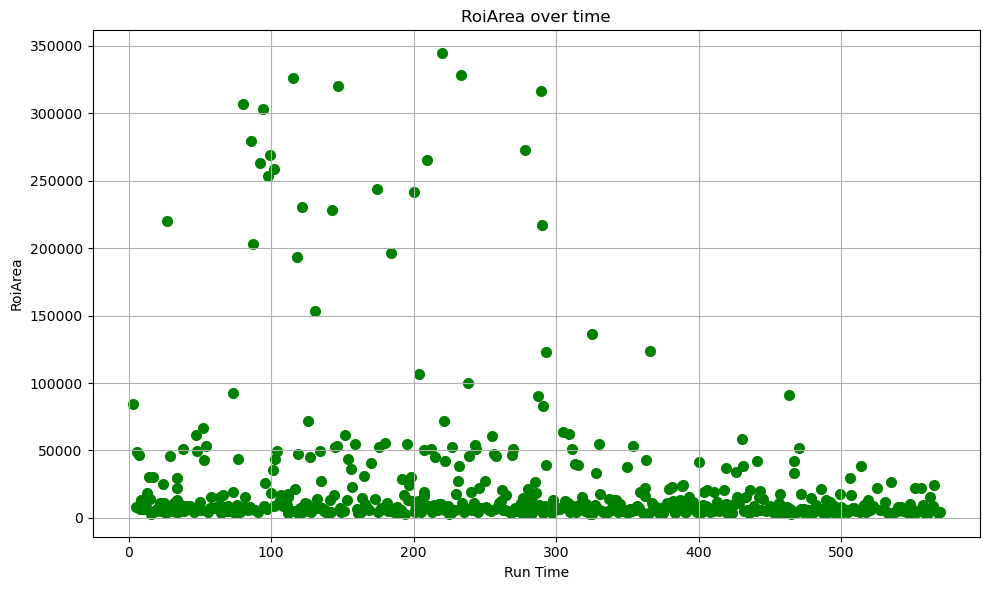

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(cleanadc_df['trigger#'], cleanadc_df['RoiArea'], color='green', linewidth=2)

plt.xlabel('Run Time')
plt.ylabel('RoiArea')
plt.title('RoiArea over time')
plt.grid(True)
plt.tight_layout()
plt.show()

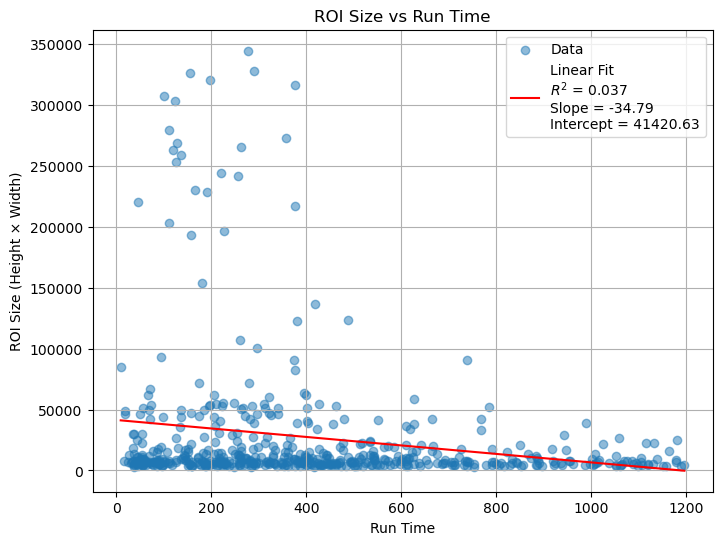

In [113]:

# Define x and y
x = cleanadc_df['RunTime']
y = cleanadc_df['RoiArea']

# Fit linear model
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# Calculate R²
residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x, y_pred, color='red', label=f'Linear Fit\n$R^2$ = {r_squared:.3f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}')

plt.xlabel('Run Time')
plt.ylabel('ROI Size (Height × Width)')
plt.title('ROI Size vs Run Time')
plt.legend(loc='best')
plt.grid(True)
plt.show()

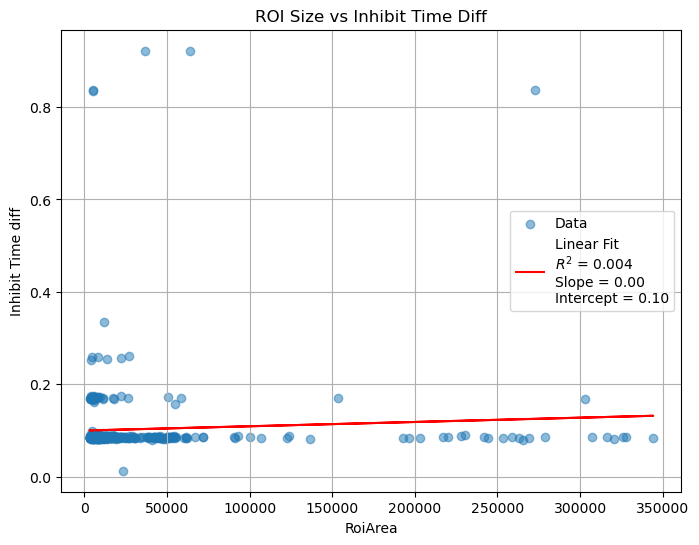

In [114]:

# Filter out rows where InhibitTimeDiff is 0
filteredadc_df = cleanadc_df[cleanadc_df['InhibitTimeDiff'] != 0]

# Define x and y
x = filteredadc_df['RoiArea']
y = filteredadc_df['InhibitTimeDiff']

# Fit linear model
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# Calculate R²
residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x, y_pred, color='red', label=f'Linear Fit\n$R^2$ = {r_squared:.3f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}')

plt.xlabel('RoiArea')
plt.ylabel('Inhibit Time diff')
plt.title('ROI Size vs Inhibit Time Diff')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## There does not seem to be an obvious increaese in inhibit time between size class i guess i could also bin by area into size classes and then do a t test of something to see but it looks to basicaly alwyas be the same with just some stocastisity